# DSCI 572 Lecture 2



In [2]:
import numpy as np
import sklearn
import sklearn.linear_model
import feather # export MACOSX_DEPLOYMENT_TARGET=10.10; pip install feather-format
%load_ext rpy2.ipython
import matplotlib.pyplot as plt
%matplotlib inline

## gradients

#### review of derivatives

Derivative: gives you the rate of change.

What about the _sign_ specifically? It gives you the _direction of change_.

#### review of gradients

[Gradient](https://en.wikipedia.org/wiki/Gradient): say you have a function $f(\mathbf{x})$ that maps $\mathbb{R}^d\rightarrow \mathbb{R}$. In other words, it takes in a vector and produces a scalar. Then its gradient is written as $\nabla f$. The gradient is also a vector of length $d$. It is a vector of the partial derivatives


$$\left(\begin{array}{c}\frac{\partial f}{\partial x_1}\\ \vdots \\ \frac{\partial f}{\partial x_d} \end{array}\right)$$

We will pay special attention to the _direction_ of the gradient. It has a similar interpretation to the sign of the derivative. It is the _direction of fastest increase_. 

Moving (with infinitesimal step size) in the gradient direction increases $f$ as much as possible (or makes $f$ stay the same if the gradient is zero). 


## let's take some gradients

1. $f(x,y) = \sin(xy)$
2. $g(\mathbf{x})= \frac{1}{2}||\mathbf{x}||^2_2$
3. $h(\mathbf{x})=A\mathbf{x}$

## gradient descent

#### use of the gradient: optimization

The (negative) gradient gives us a direction of travel, if we want to minimize a function!

If we are trying to minimize $f(\mathbf{w})$, then gradient descent works by starting with some initial guess $\mathbf{w}_0$ and then updating with

$$\mathbf{w}_{t+1} = \mathbf{w}_{t} - \alpha\, \nabla f(\mathbf{w}_{t})$$

- Note: gradient descent is an algorithm for minimization. The corresponding method for maximization is called gradient ascent.
- (optional note): physicists like me tend to think about _units_. Note that $f$ and $\nabla f$ have different units, which means the learning rate has units. That seems weird, since we'd hope to pick the learning rate irrespective of the scaling of our probelm. If this bothers you, see [this blog post](http://timvieira.github.io/blog/post/2016/05/27/dimensional-analysis-of-gradient-ascent/).


#### magnitude vs. direction

In the above we are making use of the magnitude of the gradient, not just its direction. This actually makes sense. When the magnitude is small, we are in a flatter area and want to take smaller steps. 

However, some methods exist that just use the direction. For example given a direction you can do a [line search](https://en.wikipedia.org/wiki/Line_search).

#### picking the learning rate

In general picking $\alpha$ is a pain. There is theory on this regarding convergence guarantees and convergence rates. The learning rate is sometimes decreased over time. Fancier methods pick the learning rate adaptively.

#### termination conditions

We can stop when $||\nabla f||$ is sufficiently small (because this indicates we're at a local minimum), or when a specified maximum number of iterations are reached (because we want to limit the computational expense).

#### why gradient descent

Question: why do we want to use the gradient? 

- One way to think about it is that you get $d$ times more information than just the function value
- It takes $d+1$ evaluations to estimate the gradient (we'll discuss this in lecture 4)
- Without it, you are blindly moving around (analogy: _E. coli_ vs _Dicty_)

## Least squares via normal equations vs. gradient descent:

- Normal equations cost $\mathcal{O}(nd^2 + d^3)$.
  - forming $X^TX$ costs $\mathcal{O}(nd^2)$ and solving a $d\times d$ linear system costs $\mathcal{O}(d^3)$
- Gradient descent costs $\mathcal{O}(ndt)$ to run for $t$ iterations.
  - computing $\nabla f(\mathbf{w})=X^TXw-X^Ty$ only costs $\mathcal{O}(nd)$ 
- Gradient descent can be faster when $d$ is very large
  - well, this is just big-O, we don't know the coeffcients
  - matrix operations are fast. iteration is slow, especially in Python
  - gradient descent is probably not the way to go with OLS, but we'll see its usefulness below

Let's do some experiments to test the speed of various approaches!

#### approach 1: `lm` in R

In [47]:
%%R
# generate the fake data

library(feather) # install.packages("feather")

d <- 10
N <- 1000

df = data.frame(replicate(d+1,rnorm(N)))

# we're being very careful and ensuring that all implementations use the exact same random data
path <- "my_data.feather"
write_feather(df, path)


In [48]:
%%R 
df <- read_feather(path)

lm(X1~., data=df)



Call:
lm(formula = X1 ~ ., data = df)

Coefficients:
(Intercept)           X2           X3           X4           X5           X6  
   0.001174    -0.009045    -0.009488     0.032485     0.021885     0.041790  
         X7           X8           X9          X10          X11  
   0.023937    -0.017901    -0.041342    -0.035752    -0.009985  



In [49]:
%%R 

system.time(lm(X1~., data=df))


   user  system elapsed 
  0.006   0.000   0.007 


#### approach 2: sklearn's LinearRegression in Python

In [50]:
# sklearn least squares

path = 'my_data.feather'
df = feather.read_dataframe(path)
dfm = df.as_matrix()
X = dfm[:,1:]
y = dfm[:,0]

lr = sklearn.linear_model.LinearRegression()
%timeit lr.fit(X,y)
print(lr.intercept_)
print(lr.coef_)

The slowest run took 73.99 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 566 µs per loop
0.00117357983703
[-0.00904501 -0.00948793  0.03248485  0.02188539  0.04179018  0.0239366
 -0.01790057 -0.04134153 -0.03575227 -0.0099849 ]


#### approach 3: roll-your-own gradient descent in Python

In [52]:
# add a feature of all 1's for intercept (this trick was mentioned in DSCI 573 Lecture 1)
X = np.append(np.ones(X.shape[0])[:,None], X, axis=1)

XTX = X.T@X
XTy = X.T@y

alpha = 0.00001

grad_f = lambda w: XTX@w - XTy

In [56]:
%%timeit

w = np.zeros(X.shape[1])

for t in range(1000):
    w -= alpha*grad_f(w)

    

100 loops, best of 3: 3.32 ms per loop


In [57]:
# do the same thing without timeit
w = np.zeros(X.shape[1])

for t in range(1000):
    w -= alpha*grad_f(w)

    

In [55]:
print("Intercept: %f" % w[0])
print("Weights: %s" % w[1:])

Intercept: 0.001175
Weights: [-0.00904604 -0.00948662  0.03248089  0.02188408  0.04178855  0.02393699
 -0.01789993 -0.04134251 -0.03575175 -0.00998412]


#### approach 4: roll-your-own Normal equations in Python

In [11]:
# normal equations

%timeit weights = np.linalg.solve(XTX,XTy)

weights = np.linalg.solve(XTX,XTy)

print(weights)

The slowest run took 388.52 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 15.7 µs per loop
[ 0.00313832 -0.01677082 -0.00662893 -0.00819619  0.01263048  0.06619282
  0.01806788  0.02529413  0.04439167  0.01766597  0.03029174]


#### results

| Method | Time |
|--------|------|
| `lm`   | 5 ms |
| sklearn | 1 ms |
| gradient descent | 5 ms |
| normal equations | hard to say because numpy caching, maybe 10 ms? |

So, basically they are all within the same order of magnitude in this case. And importantly they yield the same coefficients which is reassuring (and cool... math works!). 


## why gradient descent

If we can solve least squares in closed form with linear algebra, why do we want gradient descent?

Answer: we can make changes and everything still works. For example we can minimize the L1 objective

$$ \sum_{n=1}^N\left|\left|y_n-\mathbf{w}^\top(\mathbf{x_n})\right|\right|_1 =  \sum_{n=1}^N\left|y_n-\mathbf{w}^\top x_{n}\right| $$

with gradient descent. This is the sum of absolute values instead of the sum of squares. This will hopefully give us robust regression because big distances aren't amplified in the objective.

You might point out this is non-differentiable. If you are interested in this you can read about [subgradients](https://en.wikipedia.org/wiki/Subderivative). We will (irresponsibly?) ignore this issue.

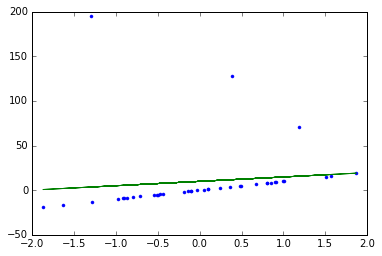

w = 4.898490
b = 9.875473


In [62]:
# generate random data
x = np.random.randn(40)
y = 10*x
# add random outliers
Noutliers = 3
y[:Noutliers] = -100*(x[:Noutliers]+np.random.randn(Noutliers))

# plot the points
plt.plot(x,y,'.')

X = x[:,None] # reshape for sklearn

# fit a linear regression model
lr = sklearn.linear_model.LinearRegression()
lr.fit(X,y)
plt.plot(x, lr.predict(X))

plt.show()


print("w = %f" % lr.coef_)
print("b = %f" % lr.intercept_)

For linear regression in one dimension our L1 objective becomes

$$\mathcal{L}(w,b)=\displaystyle \sum_{n=1}^N\left|y_n-  (w x_n +b)\right| $$

The gradient is

$$\frac{\partial \mathcal{L}}{\partial w} = \sum_{n=1}^N - x_n \textrm{sign}\left(y_n-  (w x_n +b)\right)$$ 

$$\frac{\partial \mathcal{L}}{\partial b} = \sum_{n=1}^N - \textrm{sign}\left(y_n-  (w x_n +b)\right)$$ 



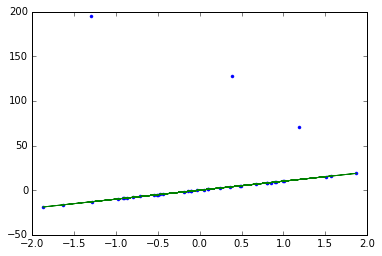

w = 10.062337
b = -0.000000


In [63]:
w = 0
b = 0
alpha = 0.01

Nsteps = 1000
f = lambda x,w,b: w*x+b

for t in range(Nsteps):
    dLdw = -np.sum(x*np.sign(y-f(x,w,b)))
    dLdb = -np.sum(np.sign(y-f(x,w,b)))
    w -= alpha*dLdw
    b -= alpha*dLdb
    
plt.figure()
plt.plot(x,y,'.')
plt.plot(x,w*x+b)
plt.show()

print("w = %f" % w)
print("b = %f" % b)


(optional): for more than 1-dimensional linear regression our L1 objective becomes

$$\displaystyle \sum_{n=1}^N\left|\left|y_n-\mathbf{w}^\top\mathbf{x_n}\right|\right|_1= \sum_{n=1}^N\sum_{i=1}^d \left|y_n-w_i x_{ni}\right|$$

The gradient w.r.t. $w_i$ is

$$\sum_{n=1}^N - x_{ni} \textrm{sign}\left(y_n-w_i x_{ni}\right)$$

## What space am I in?

A key point is being able to move around between $x$ space and $w$ space. The above diagrams are in $y$ vs. $x$ space. Here's what the loss looks like:

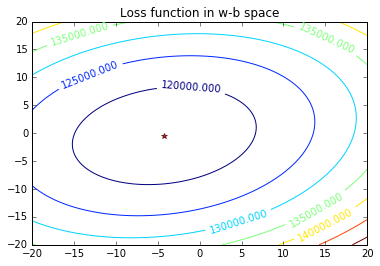

In [45]:
m = 100
w_lin = np.linspace(-20.0, 20.0, m)
b_lin = np.linspace(-20.0, 20.0, m)
w_grid, b_grid = np.meshgrid(w_lin, b_lin)

pred = w_grid.flatten()[None]*X + b_grid.flatten()[None]

loss = np.sum((pred-y[:,None])**2,axis=0)

loss = np.reshape(loss,[m,m])

plt.figure()
CS = plt.contour(w_grid, b_grid, loss)
plt.plot(lr.coef_, lr.intercept_, 'r*')

plt.clabel(CS, inline=1, fontsize=10)
plt.title('Loss function in w-b space')

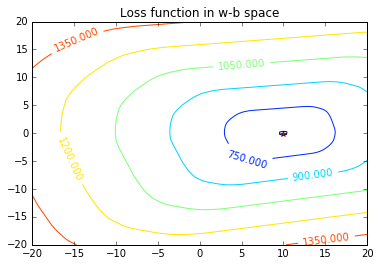

In [46]:
loss = np.sum(np.abs(pred-y[:,None]),axis=0)

loss = np.reshape(loss,[m,m])

plt.figure()
CS = plt.contour(w_grid, b_grid, loss)
plt.plot(w, b, 'r*')

plt.clabel(CS, inline=1, fontsize=10)
plt.title('Loss function in w-b space')

Key intuition: every point in weight space corressponds to a _model_ (in this case a line) in input-output space.

## logistic regression

(go through provided code in lab 1 and explain/derive the loss/grad)

## multi-class logistic regression (lab 1 question 3b)

- each class gets its own weight vector
- so we store all the weights in a matrix W for convenience
- when we predict, we end up with a number for each class that comes from $w_c^\top x_i$
- we have $C$ such numbers and we want to turn them into probabilities that sum to 1
- use "softmax" strategy
  - take $\exp$ of each number: now they are all positive
  - divide by their sum: now they sum to 1
- we will return to this in lecture 6 when we talk about neural networks for multi-class classification

The optional lab question 3b asks you to implement this. I've described how the prediction works but you'll need to compute the gradient. There are a few possible loss functions but you can just use the same one we've been using: the output probability corresponding to the true class. 

By the way, to make a hard prediction (just give me your best shot), you don't need the softmax. Because the biggest raw output will become the biggest probability. So you can just do $y_i=\arg\max_c w_c^\top x_i$.

## multi-class intuition (lab 1 question 4b)

Question: if you train on a mutli-class problem, how will you do on a one-vs-all (binary) classification problem?

(BTW, the "1" in one-vs-all doesn't mean the class "1" vs other classes. It just means one of the classes versus the rest. A bit confusing...)

#### confusion matrix view (same training/prediction, different evaluation)

Consider 4-class classification

|   | 1  |  2   | 3  | 4|
|---|-----|----|---|----|
| **1** |  o  |    |   |    |
| **2** |     | o  |   |    |
| **3** |     |    | o |    |
| **4** |     |    |   |  o |

Correct answers are marked with 'o'. 

Now consider the 2-vs-all problem.


|   | 1 (no) |  2 (yes)  | 3 (no)  | 4 (yes) |
|---|-----|----|---|----|
| **1 (no)** |  o  |    | o | o  |
| **2 (yes)** |     | o  |   |    |
| **3 (no)** |  o  |    | o | o  |
| **4 (no)** |  o  |    | o | o  |

Again, correct answers are marked with 'o'. 

- So, we can see that if we make the predictions, the one-vs-all problem is _strictly easier_.
- This is the case of two models trained in the same way (or just one model), but tested differently

But then we can ask a more subtle question, which is the one in the lab:

- What if we have two models trained differently, but tested in the same way?
- In particular, one is trained on one-vs-all, and the other is trained on multi-class, but we ask how well both do on one-vs-all.

#### KNN example (different training/prediction, same evaluation)

Example: KNN with $k=5$. For some particular test example, the $k$ nearest neighbours have labels 2,2,3,4,5.

**Case 1: one-vs-all**

In the one-vs-all case, this will have been convered to: {yes, yes, no, no, no}. So the KNN takes the mode and votes "no".

**Case 1: mutli-class**

In the multi-class case, we have 2,2,3,4,5 and we take the mode and vote "2". We then convert this to yes/no _after_ predicting and end up with "yes". So the two classifiers behave differently.

Although logistic regression works very differently from KNN, the same type of thing can happen and the two training methods can give _different predictions_ on the same one-vs-all test set.

We have now showed how the predictions can be different. It's up to you to think about which one will be better. It's possible to make a pretty convincing argument. 
